# Retail Demand Forecasting  
## Problem Description  
The organization needs to understand sale quantity forecasts to accurately stock items between Nov. 27th 2011 and Dec. 3rd 2011  

## Method  
Create a regression model for quantity prediction based on location and time data for features.  
Prediction will be analysed for each product StockCode and Country seperately, but executed from a single model.  
Models will be reviewed accross many metrics, but primary selected based on r^2 to ensure variance is accurately modeld.  
Nov. 27th 2011 and Dec. 3rd 2011 quantities are removed from all training and evaluation and used only for final review of the selected model.  
Cross validation will be performed with 4 folds of progressive time series splits.  

The chosen prediction method is using a regression model because it will scale best as prediction factors grow, including countries, codes, etc.  
A form of ARIMA modeling would likely work well, but would require indipendent models for each code and country to provide predictions  
for these categorical factors.

## Assumptions  
Model training, predictions and evaluation are performed on only the top 3 selling items,  
data analysis and distribution assesment are performed on the complete dataset  


In [24]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot

import datetime

from sklearn.metrics import max_error, mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, r2_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import make_column_transformer
from sklearn.model_selection import cross_validate, TimeSeriesSplit, GridSearchCV

from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import AdaBoostRegressor, GradientBoostingRegressor, HistGradientBoostingRegressor
from sklearn.linear_model import PoissonRegressor

from joblib import dump, load

import warnings
warnings.filterwarnings('ignore')

In [25]:
def date_series(s, dates, fill_val = np.NaN):
    """
    Assigns a time indexed sereis to a new time index date range
    INPUT:
        s (Sereis) - Pandas series with a DatetimeIndex
        dates (List[Datatime]) - Range of datetime values for new new index
        fill_val (Same type as items in s) - Default value to apply when new index hase dates not in original index
    OUPUT:
        Pandas series with date time index matching the input date values
    """
    return s.reindex(pd.DatetimeIndex(dates), fill_value = fill_val)


def code_feature_constructor(df, code, country, dates, max_lag = 3):
    """
    Constructs time series features used for supervised model for a single code and country
    INPUT:
        df (DataFrame) - Pandas dataframe containing Date, Quantity and StockCode columns
        code (String) - Stock codes selected for feature construction
        country (String) - Country selected for feature construction
        dates (List[Datetime]) - Range of dates for dataset index
        max_lag (Int) - Number of days to calculate lag values from differenced data 
    OUTPUT:
        Pandas dataframe with differencing and time series features for supervised model
    """
    part_df = pd.DataFrame()
    part_df['StockCode'] = date_series(pd.Series([code]), dates, code)
    part_df['Quantity'] = date_series(pd.Series(df['Quantity'].to_list(), pd.DatetimeIndex(df['Date'])), dates, 0)
    part_df['QuantityDiff'] = part_df['Quantity'].diff()
    part_df['UnitPrice'] = date_series(pd.Series(df['UnitPrice'].to_list(), pd.DatetimeIndex(df['Date'])), dates)
    part_df['DayOfWeek'] = part_df.index.dayofweek
    part_df['Month'] = part_df.index.month
    part_df['Country'] = date_series(pd.Series([country]), dates, country)
    
    # Add lag features based on input duration
    for lag in range(1, max_lag + 1, 1):
        part_df[f'Lag_{str(lag)}'] = part_df['QuantityDiff'].shift(lag)
    
    part_df.index = part_df.index.rename('Date')
    return part_df.sort_values('Date').ffill()


def feature_constructor(df, max_lag = 3):
    """
    Constructs time series features for supervised model for all codes and countries
    INPUT:
        df (DataFrame) - Pandas dataframe containing Date, Quantity and StockCode columns
        max_lag (Int) - Number of days to calculate lag values from differenced data 
    OUTPUT:
        new_df (DataFrame) - Pandas dataframe with time series fields for all records
    """
    dates = pd.date_range(df['Date'].min(), df['Date'].max())
    df['CodeCountry'] = df['StockCode'].str.cat(df['Country'],sep="|")
    code_country = df['CodeCountry'].drop_duplicates().to_numpy()
    args = ((df[df['CodeCountry'] == cc], cc.split('|')[0], cc.split('|')[1], dates, max_lag) for cc in code_country)
    df_list = list(map(lambda x: code_feature_constructor(*x), args))

    new_df = pd.concat(df_list).sort_values('Date')
    new_df['pad'] = 1
    return new_df


def format_data(df, max_lag = 7):
    """
    Master function to format all data for supervised training with time indexes and grouped by StockCode and Country
    INPUT:
        df (DataFrame) - Pandas dataframe containing Date, Quantity and StockCode columns
        max_lag (Int) - Number of days to calculate lag values from differenced data 
    OUTPUT:
        new_df (DataFrame) - Pandas dataframe with time series fields for all records
    """
    df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'], infer_datetime_format=True)
    df['Date'] = df['InvoiceDate'].dt.date
    df = df.groupby(['StockCode', 'Country', 'Date']).agg({'Quantity': 'sum', 'UnitPrice': 'mean'}).sort_values('Date').reset_index()
    return feature_constructor(df, max_lag)


def train_test_data(df, codes, test_start, test_end):
    """
    Splits data into train and test sets based on specified test window and evaluation codes
    INPUT:
        df (DataFrame) - Pandas dataframe with data formatted for supervised learning
        codes (List[String]) - StockCodes targeted for model predictions
        test_start (Datetime) - Start time for testing window
        test_end (Datetime) - End time of testing window
    OUTPUT:
        train_X (DataFrame) - Pandas dataframe containing feature data for training
        train_y (Series) - Pandas series containing label data for training
        test_X (DataFrame) - Pandas dataframe containing feature data for testing
        test_y (Series) - Pandas series containing label data for testing
    """
    df = df.reset_index()
    test_df = df[df['StockCode'].isin(codes)][df['Date'] >= test_start][df['Date'] <= test_end].dropna()
    train_df = df[df['Date'] < test_start].dropna()
    test_X = test_df.drop(['Date', 'QuantityDiff'], axis = 1)
    test_y = test_df['QuantityDiff']
    train_X = train_df.drop(['Date', 'QuantityDiff'], axis = 1)
    train_y = train_df['QuantityDiff']
    return train_X, train_y, test_X, test_y


def experiment(X, y, prep, regrs, metrics):
    """
    Wrapper function to run experiment comparing a list of regression models
    INPUT:
        X (DataFrame) - Pandas dataframe containing feature data for training
        y (Series) - Pandas series containing label data for training
        prep (Pipeline) - Scikit-Learn pipeline for preprocessing feature data
        regrs (Model) - Scikit-Learn regression model
        metrics (List[String]) - list of metrics used for displaying experiment results
    OUTPUT:
        models (List[Pipeline Models]) - List of pipeline models evaluated in the experiment
        exp_df (DatFrame) - Pandas dataframe displaying the metric results of the experiment
    """
    exp_df_list = []
    models = []
    tscv = TimeSeriesSplit(n_splits=4)
    for model_name, model in regrs:
        if model_name in ['PoissonRegressor', 'HistGradientBoostingRegressor']:
            y = y.clip(lower = 0)
        pipe_model = make_pipeline(prep, model)
        cv_results = cross_validate(pipe_model, X, y, cv = tscv, scoring = metrics)
        metric_data = [[model_name] + [cv_results[f'test_{m}'].mean() for m in metrics]]
        tdf = pd.DataFrame(metric_data, columns = ['Model'] + metrics)
        exp_df_list.append(tdf)
        models.append(pipe_model)
    exp_df = pd.concat(exp_df_list)
    return models, exp_df

def get_metrics_df(model_name, y_true, y_pred):
    """
    Provides model evaluation metrics in easy to read format
    INPUT:
        model_name (Sting) - Name of the model for display purposes
        y_true (List,Array,Series) - True label values
        y_pred (List,Array,Series) - Predited label values
    OUTPUT:
        metric_df (DataFrame) - Pandas dataframe displaying metrics for input values
    """
    metric_df = pd.DataFrame({
        'Model': [model_name],
        'me': [max_error(y_true, y_pred)],
        'mae': [mean_absolute_error(y_true, y_pred)],
        'mse': [mean_squared_error(y_true, y_pred)],
        'mape': [mean_absolute_percentage_error(y_true, y_pred)],
        'r2': [r2_score(y_true, y_pred)]
    })
    return metric_df

In [26]:
read_df = pd.read_csv('Online Retail.csv', encoding = 'unicode_escape')

top_count = 3
top_codes = read_df.groupby('StockCode').sum().sort_values('Quantity', ascending = False).index.values[:top_count].tolist()

## Data Priview of First 5 Records

In [27]:
read_df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/10 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/10 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/10 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/10 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/10 8:26,3.39,17850.0,United Kingdom


## Data Preview By Unit Cost  
We see that there are some extreme outliers for unit cost. If we take a closer look at these many have nothing to do with stocking.  
For this reason we can drop many of these outlier fields, the chosen fields to drop are:  

Manual, AMAZON FEE, Adjust bad debt, POSTAGE, DOTCOM POSTAGE, Discount, CRUK Commission, and Bank Charges

In [28]:
read_df['abs'] = np.abs(read_df['UnitPrice'])
read_df.sort_values('abs', ascending = False).head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,abs
222681,C556445,M,Manual,-1,6/10/11 15:31,38970.00,15098.0,United Kingdom,38970.00
524602,C580605,AMAZONFEE,AMAZON FEE,-1,12/5/11 11:36,17836.46,NaN,United Kingdom,17836.46
43702,C540117,AMAZONFEE,AMAZON FEE,-1,1/5/11 9:55,16888.02,NaN,United Kingdom,16888.02
43703,C540118,AMAZONFEE,AMAZON FEE,-1,1/5/11 9:57,16453.71,NaN,United Kingdom,16453.71
15016,C537630,AMAZONFEE,AMAZON FEE,-1,12/7/10 15:04,13541.33,NaN,United Kingdom,13541.33


In [29]:
drop_descriptions = ['Manual', 'AMAZON FEE', 'Adjust bad debt', 'POSTAGE','DOTCOM POSTAGE', 'Discount', 'CRUK Commission', 'Bank Charges']
read_df = read_df[~read_df['Description'].isin(drop_descriptions)]

Once these fields are dropped we have significantly reduced our outlier count, shown below:

In [30]:
read_df.sort_values('abs', ascending = False).head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,abs
222680,556444,22502,PICNIC BASKET WICKER 60 PIECES,60,6/10/11 15:28,649.5,15098.0,United Kingdom,649.5
222682,556446,22502,PICNIC BASKET WICKER 60 PIECES,1,6/10/11 15:33,649.5,15098.0,United Kingdom,649.5
242589,C558359,S,SAMPLES,-1,6/28/11 15:10,570.0,NaN,United Kingdom,570.0
133994,547814,22656,VINTAGE BLUE KITCHEN CABINET,1,3/25/11 14:19,295.0,13452.0,United Kingdom,295.0
171178,551393,22656,VINTAGE BLUE KITCHEN CABINET,1,4/28/11 12:22,295.0,14973.0,United Kingdom,295.0


## Data Description for Distribution and Null Values

In [31]:
read_df.describe()

,Quantity,UnitPrice,CustomerID,abs
count,539209.000000,539209.000000,405047.000000,539209.000000
mean,9.589649,3.287615,15294.934894,3.287615
std,218.588222,4.679483,1710.230148,4.679483
min,-80995.000000,0.000000,12346.000000,0.000000
25%,1.000000,1.250000,13969.000000,1.250000
50%,3.000000,2.080000,15159.000000,2.080000
75%,10.000000,4.130000,16794.000000,4.130000
max,80995.000000,649.500000,18287.000000,649.500000


After previewing the data we can focus analysis on StockCode, InvoiceDate, UnitPrice, and Country.  
For stocking prediction purposes we do not care which customers are buying nor the description of the item  
now that we have removed the outlier codes.
## StockCode Quantities by Day  

<AxesSubplot:xlabel='Date'>

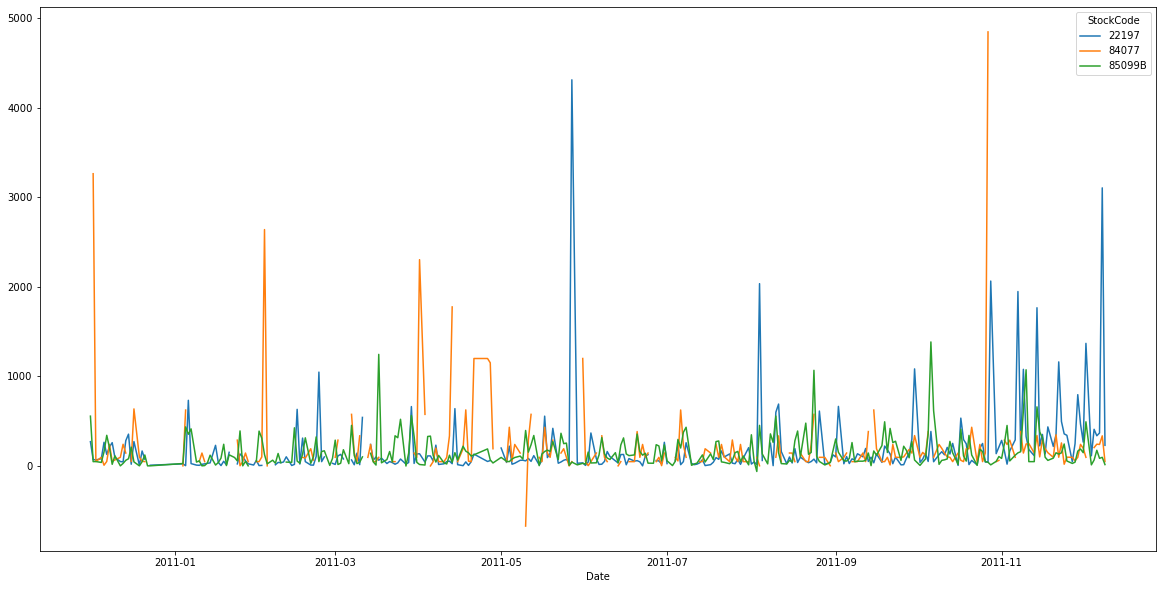

In [32]:
df = read_df.copy()
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'], infer_datetime_format=True)
df['Date'] = df['InvoiceDate'].dt.date
(
    df.groupby(['Date', 'StockCode']).sum().reset_index()
    .pivot(index = 'Date', columns = 'StockCode', values = 'Quantity')
    .reset_index()[['Date'] + top_codes]
    .plot.line('Date', top_codes, figsize = (20, 10))
)

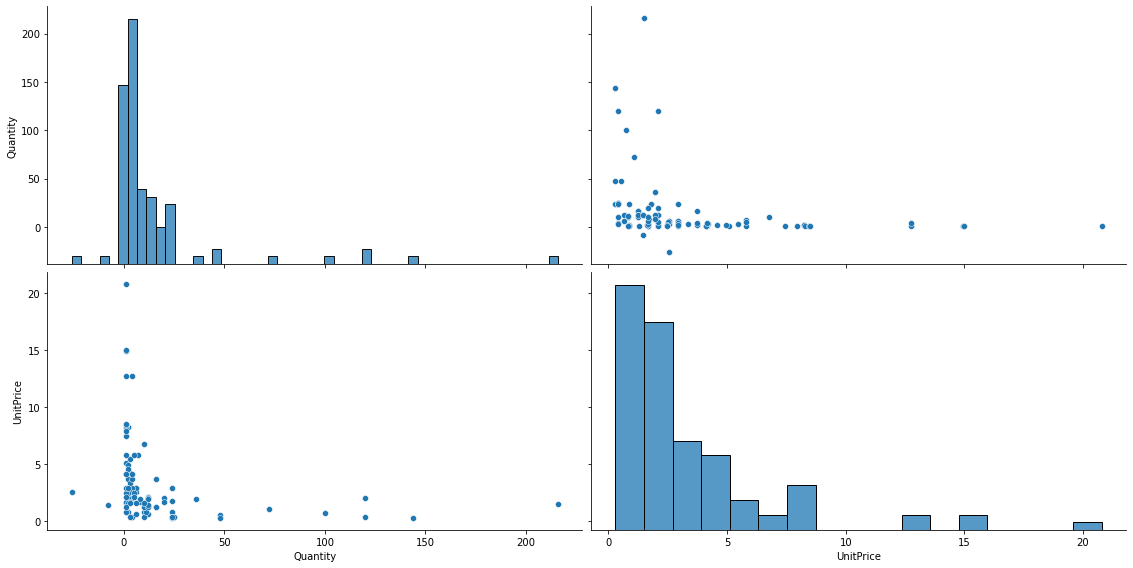

In [33]:
ids = np.random.randint(0, read_df.shape[0], 100)
sns.pairplot(read_df[['Quantity', 'UnitPrice']].iloc[ids], height = 4, aspect = 2)

After charting the data we see a notecible Poisson distribution to UnitCost and Quantity, this is not surprising as high cost items  
are typically purchased less frequently, but it is worth noting as for model considerations later.
## Feature Creation  
For this analysis we focus features creation primarily on time based factors in addition to counrty. The time based features are:  
- Month  
- Day of Week  
- Differenced Quantities  
- 1 to 7 day lags of Differenced Quantities  


In [34]:
max_lag = 7
df = read_df.copy()[read_df['StockCode'].isin(top_codes)]
feature_df = format_data(df, max_lag)

## Modeling  
Because some of the data is categorical and different features have different distributions, the final model first  
encodes and scales all features before selecting the regressor.  

Regressor selection starts with an analysis of 4 base models:
- To account for the poisson distributions PoissonRegressor and HistGradientBoostingRegressor are evaluated  
- Because of the large encoding space for categorical variables AdaBoostRegressor and GradientBoostingRegressor are also evaluated

In [35]:
eval_start_date = datetime.datetime(2011, 11, 27)
eval_end_date = datetime.datetime(2011, 12, 3)

ml_df = feature_df.copy()
train_X, train_y, test_X, test_y = train_test_data(ml_df, top_codes, eval_start_date, eval_end_date)

In [36]:
num_cols = ['UnitPrice'] # ['QuantityDiff', 'UnitPrice'] 
num_cols += [f'Lag_{str(lag)}' for lag in range(1, max_lag + 1, 1)]
cat_cols = ['StockCode', 'DayOfWeek', 'Country']

num_pipeline = make_pipeline(StandardScaler())
cat_pipeline = make_pipeline(OneHotEncoder(handle_unknown = 'ignore', sparse = False))

preprocessor = make_column_transformer(
    (num_pipeline, num_cols),
    (cat_pipeline, cat_cols)
)

regressors = [
    ('PoissonRegressor', PoissonRegressor()),
    ('HistGradientBoostingRegressor', HistGradientBoostingRegressor(loss = 'poisson')),
    ('AdaBoostRegressor', AdaBoostRegressor()), 
    ('GradientBoostingRegressor', GradientBoostingRegressor())
]

metrics = [
    'max_error',
    'neg_mean_absolute_error',
    'neg_mean_squared_error',
    'neg_mean_absolute_percentage_error',
    'r2'
]
model_list, exp_result_df = experiment(train_X, train_y, preprocessor, regressors, metrics)

### Regressor Performance Comparison

In [37]:
exp_result_df

,Model,max_error,neg_mean_absolute_error,neg_mean_squared_error,neg_mean_absolute_percentage_error,r2
0,PoissonRegressor,-2948.041811,-12.768822,-8514.611073,-2.533795e+16,0.066121
0,HistGradientBoostingRegressor,-2929.463542,-9.758653,-8312.813432,-9.943734e+15,0.068479
0,AdaBoostRegressor,-3275.841804,-121.508275,-25683.703385,-5.051117e+17,-3.428461
0,GradientBoostingRegressor,-2884.135034,-14.747914,-9309.565634,-3.391754e+16,-0.091819


Based on most of the evaluated metrics and particularly r^2 the GradientBoostingRegressor out performed the other models  
explaining about 9.2% of the variance in the data. Next we perform a grid search for hyper parameter tuning of this model.

In [48]:
gbr_params = {
    'gradientboostingregressor__loss': ['ls'], 
    'gradientboostingregressor__learning_rate': [0.01, 0.001], 
    'gradientboostingregressor__n_estimators': [100, 1000, 10000], 
    'gradientboostingregressor__subsample': [1.0], 
    'gradientboostingregressor__criterion': ['friedman_mse'],  
    'gradientboostingregressor__max_depth': [1, 3, 10], 
    'gradientboostingregressor__min_impurity_decrease': [0.0, 0.01]
}
num_cols = ['UnitPrice'] # ['QuantityDiff', 'UnitPrice'] 
num_cols += [f'Lag_{str(lag)}' for lag in range(1, max_lag + 1, 1)]
cat_cols = ['StockCode', 'DayOfWeek']

num_pipeline = make_pipeline(StandardScaler())
cat_pipeline = make_pipeline(OneHotEncoder(handle_unknown = 'ignore'))

preprocessor = make_column_transformer(
    (num_pipeline, num_cols),
    (cat_pipeline, cat_cols)
)
pipe_model = make_pipeline(preprocessor, GradientBoostingRegressor())

tscv = TimeSeriesSplit(n_splits=4)
cv_gbr_model = GridSearchCV(pipe_model, gbr_params, cv = tscv, verbose = 1)
cv_gbr_model.fit(train_X, train_y)
cv_scores_df = pd.DataFrame(cv_gbr_model.cv_results_).sort_values(by='rank_test_score')

Fitting 4 folds for each of 36 candidates, totalling 144 fits


### Grid Search Performance Comparison

In [49]:
pd.set_option("max_colwidth", 400)
disp = cv_scores_df.copy()
disp['Params'] = [{k.split('__')[-1]: v for k, v in p.items()} for p in cv_scores_df['params']]
disp[['Params', 'mean_test_score', 'std_test_score', 'rank_test_score']]

,Params,mean_test_score,std_test_score,rank_test_score
20,"{'criterion': 'friedman_mse', 'learning_rate': 0.001, 'loss': 'ls', 'max_depth': 1, 'min_impurity_decrease': 0.0, 'n_estimators': 10000, 'subsample': 1.0}",0.391349,0.048736,1
23,"{'criterion': 'friedman_mse', 'learning_rate': 0.001, 'loss': 'ls', 'max_depth': 1, 'min_impurity_decrease': 0.01, 'n_estimators': 10000, 'subsample': 1.0}",0.391345,0.048736,2
4,"{'criterion': 'friedman_mse', 'learning_rate': 0.01, 'loss': 'ls', 'max_depth': 1, 'min_impurity_decrease': 0.01, 'n_estimators': 1000, 'subsample': 1.0}",0.391327,0.048774,3
1,"{'criterion': 'friedman_mse', 'learning_rate': 0.01, 'loss': 'ls', 'max_depth': 1, 'min_impurity_decrease': 0.0, 'n_estimators': 1000, 'subsample': 1.0}",0.391318,0.048772,4
5,"{'criterion': 'friedman_mse', 'learning_rate': 0.01, 'loss': 'ls', 'max_depth': 1, 'min_impurity_decrease': 0.01, 'n_estimators': 10000, 'subsample': 1.0}",0.326113,0.139134,5
2,"{'criterion': 'friedman_mse', 'learning_rate': 0.01, 'loss': 'ls', 'max_depth': 1, 'min_impurity_decrease': 0.0, 'n_estimators': 10000, 'subsample': 1.0}",0.326098,0.139127,6
6,"{'criterion': 'friedman_mse', 'learning_rate': 0.01, 'loss': 'ls', 'max_depth': 3, 'min_impurity_decrease': 0.0, 'n_estimators': 100, 'subsample': 1.0}",0.309458,0.041226,7
9,"{'criterion': 'friedman_mse', 'learning_rate': 0.01, 'loss': 'ls', 'max_depth': 3, 'min_impurity_decrease': 0.01, 'n_estimators': 100, 'subsample': 1.0}",0.307566,0.040380,8
25,"{'criterion': 'friedman_mse', 'learning_rate': 0.001, 'loss': 'ls', 'max_depth': 3, 'min_impurity_decrease': 0.0, 'n_estimators': 1000, 'subsample': 1.0}",0.306514,0.039938,9
28,"{'criterion': 'friedman_mse', 'learning_rate': 0.001, 'loss': 'ls', 'max_depth': 3, 'min_impurity_decrease': 0.01, 'n_estimators': 1000, 'subsample': 1.0}",0.305787,0.040494,10


In [50]:
pd.concat([
    get_metrics_df('GradientBoostingRegressor', train_y, cv_gbr_model.predict(train_X)),
    get_metrics_df('GradientBoostingRegressor_Test', test_y, cv_gbr_model.predict(test_X.dropna()))
])

,Model,me,mae,mse,mape,r2
0,GradientBoostingRegressor,4574.570488,14.954421,8752.477312,1.013717e+16,0.480886
0,GradientBoostingRegressor_Test,1016.616426,13.494014,5697.271281,8.353773e+15,0.529249


In [41]:
results_df = feature_df.copy().reset_index().dropna()
X = results_df.drop(['Date', 'QuantityDiff'], axis = 1)
y = results_df['QuantityDiff']
results_df['prediction'] = cv_gbr_model.predict(X.dropna())
select_cols = [i for i in results_df.columns if i != 'QuantityDiff'] + ['QuantityDiff']
results_df = results_df[select_cols]
results_df.to_csv('Paul_McMullen_result.csv')

The final model is performing better after hyper parameter tuning, explaining about 50% of the variance in the data. Using this model for prediction on the forecast window we see it performed reasonably well.
## Format and Display Results

In [42]:
ml_df_true = ml_df.copy().dropna()
ml_df_true['CodeCountry'] = ml_df_true['StockCode'].str.cat(ml_df_true['Country'],sep="|")
ml_df_true['Date'] = ml_df_true.index
ml_df_true = ml_df_true.pivot(index = 'Date', columns = 'CodeCountry', values = 'QuantityDiff').reset_index()

ml_df_pred = ml_df.copy().dropna()
ml_df_pred['CodeCountry'] = ml_df_pred['StockCode'].str.cat(ml_df_pred['Country'],sep="|")
ml_df_pred['Date'] = ml_df_pred.index
ml_df_pred['PredictedQuantity'] = cv_gbr_model.predict(ml_df_pred[train_X.columns])
ml_df_pred = ml_df_pred.pivot(index = 'Date', columns = 'CodeCountry', values = 'PredictedQuantity').reset_index()
ml_df_pred.columns = [f'{c}_Pred' for c in ml_df_true.columns]

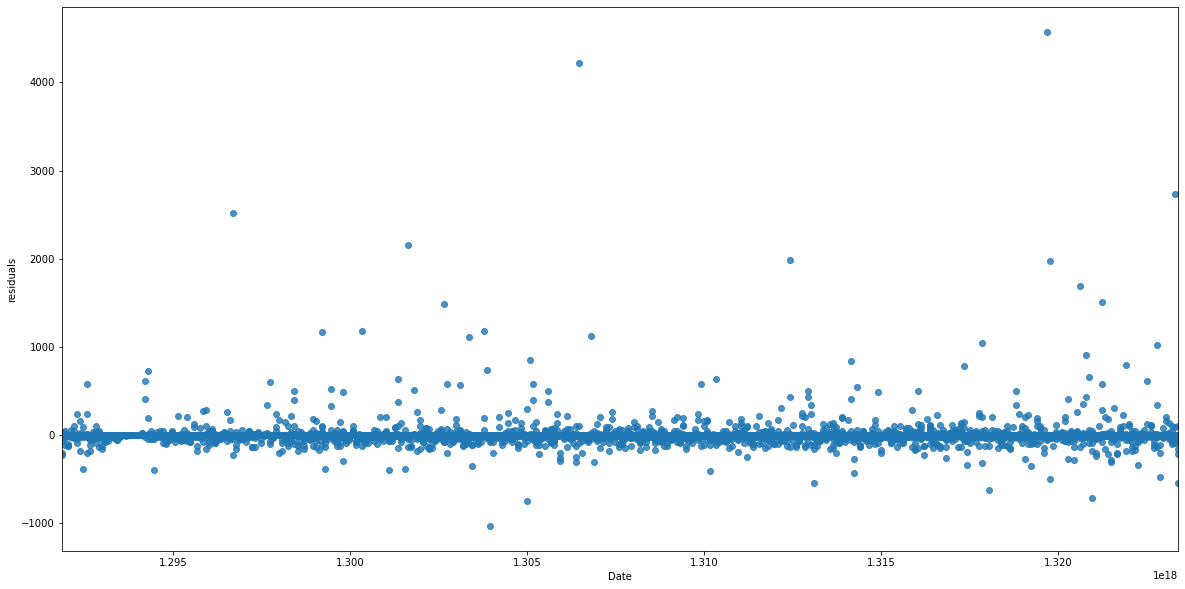

In [43]:
ml_df_res = ml_df.copy().dropna()
ml_df_res['Date'] = ml_df_res.index.astype(int)
ml_df_res['PredictedQuantity'] = cv_gbr_model.predict(ml_df_res[train_X.columns])
ml_df_res['residuals'] =  ml_df_res['QuantityDiff'] - ml_df_res['PredictedQuantity']

c = sns.regplot(x = ml_df_res['Date'], y = ml_df_res['residuals'])
c.figure.set_size_inches(20, 10)

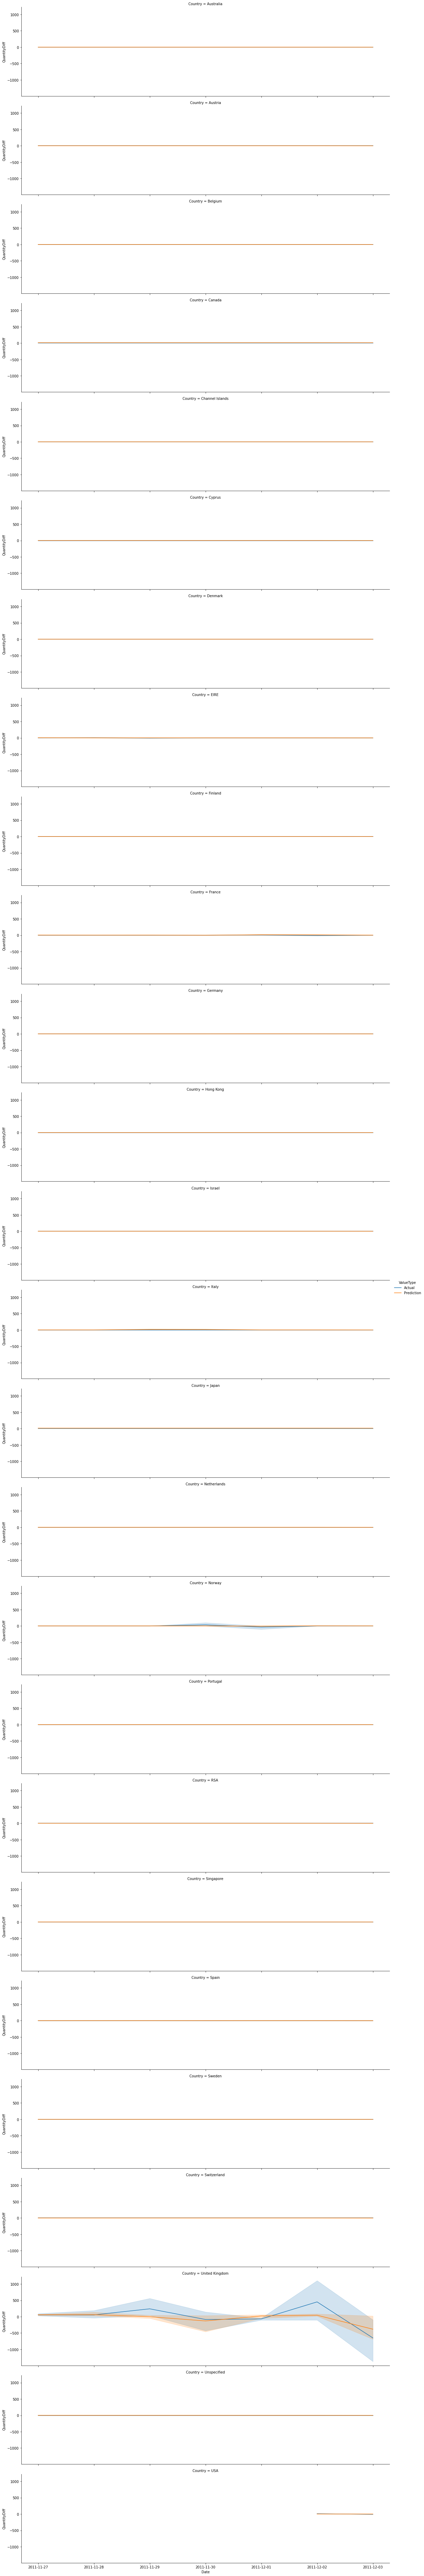

In [47]:
eval_start_date = datetime.datetime(2011, 11, 27)
eval_end_date = datetime.datetime(2011, 12, 3)

plot_df = results_df.copy()
actual_plot_df = plot_df[['Date', 'Country', 'QuantityDiff']]
pred_plot_df = plot_df[['Date', 'Country', 'prediction']]
pred_plot_df = pred_plot_df.rename(columns = {'prediction': 'QuantityDiff'})
actual_plot_df['ValueType'] = 'Actual'
pred_plot_df['ValueType'] = 'Prediction'

plot_df = pd.concat([actual_plot_df, pred_plot_df]).sort_values(['Date', 'Country', 'ValueType'])
plot_df = plot_df[plot_df['Date'].between(eval_start_date, eval_end_date)]

g = sns.FacetGrid(plot_df, row = 'Country', hue = 'ValueType', height = 4, aspect = 4)
g.map(sns.lineplot, 'Date', 'QuantityDiff')
g.add_legend()

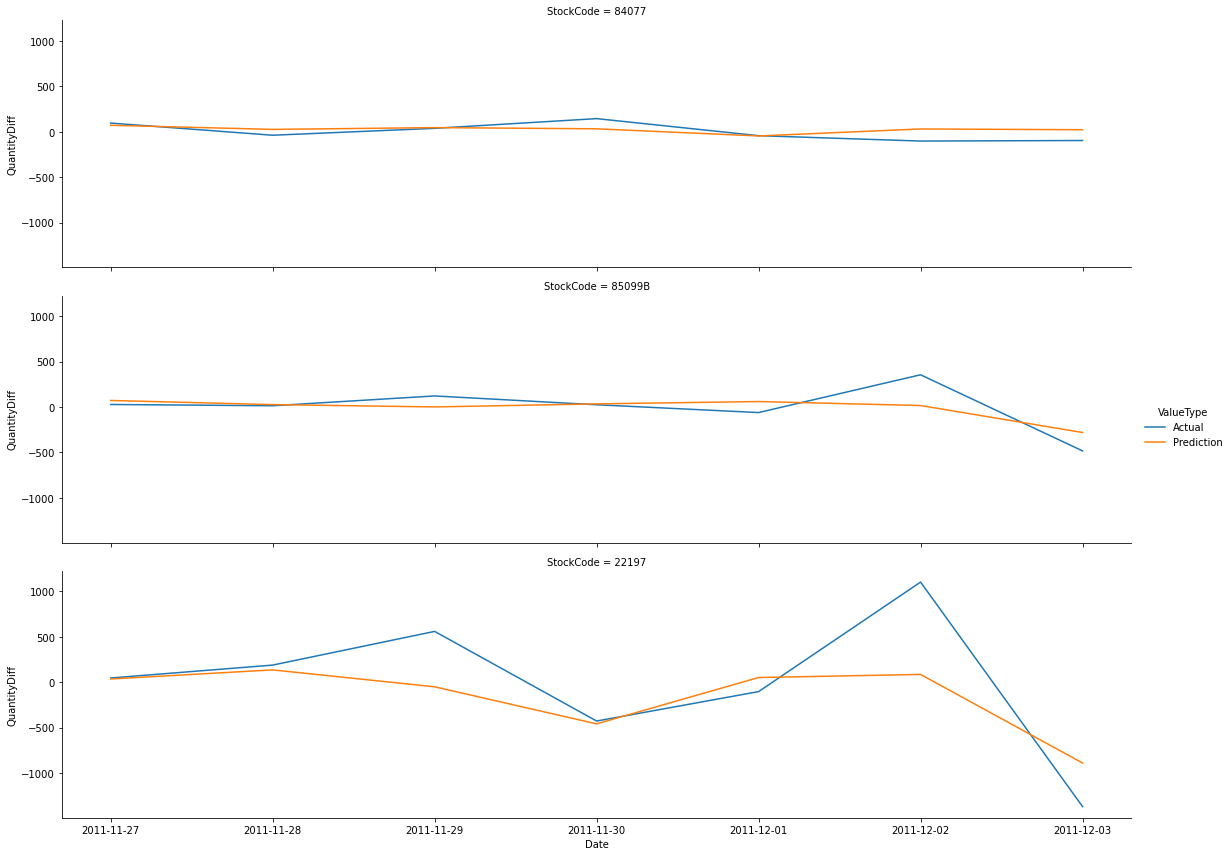

In [45]:
eval_start_date = datetime.datetime(2011, 11, 27)
eval_end_date = datetime.datetime(2011, 12, 3)

plot_df = results_df.copy()[results_df['Country'] == 'United Kingdom']
actual_plot_df = plot_df[['Date', 'StockCode', 'Country', 'QuantityDiff']]
pred_plot_df = plot_df[['Date', 'StockCode', 'Country', 'prediction']]
pred_plot_df = pred_plot_df.rename(columns = {'prediction': 'QuantityDiff'})
actual_plot_df['ValueType'] = 'Actual'
pred_plot_df['ValueType'] = 'Prediction'

plot_df = pd.concat([actual_plot_df, pred_plot_df]).sort_values(['Date', 'Country', 'ValueType'])
plot_df = plot_df[plot_df['Date'].between(eval_start_date, eval_end_date)]

g = sns.FacetGrid(plot_df, row = 'StockCode', hue = 'ValueType', height = 4, aspect = 4)
g.map(sns.lineplot, 'Date', 'QuantityDiff')
g.add_legend()

In [46]:
dump(cv_gbr_model, './models/country_model_top3.joblib')
load_model = load('./models/country_model_top3.joblib')

## Next Steps  
A good next step to evaluate this model is to compare prediction performance agains ARIMA models for the top three codes in the UK.  
This model also uses 7 lag periods based on assumptions made about weekly purchasing behavior, it would be valuable to further analyse  
the periodicity of these stock codes. Likely one of the most valuable improvements would be a larger dataset including past years,  
especially over the prediction month/day period. The increase in quantities and variablility during this time period is likely due to the  
Christmas holiday, meaning this is likely a periodic behavior we can better capture with more historical data. Because boosting methods  
appear to work best for this dataset it would also be interesting to test performance with XGBoost models as well as Neural Networks like LSTM  
for future experiments.